In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-rf

     |████████████████████████████████| 20.6 MB 68 kB/s  eta 0:00:01    |███████████▊                    | 7.5 MB 5.5 MB/s eta 0:00:03     |████████████████▉               | 10.8 MB 5.5 MB/s eta 0:00:02
     |████████████████████████████████| 1.6 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 242 kB 10.3 MB/s eta 0:00:01
  Created wheel for scikit-rf: filename=scikit_rf-0.20.0-py3-none-any.whl size=2229179 sha256=0e57da869834ebffb0f946e25ffc9dbd0e30a496688013e4fc52dba8ed630182
  Stored in directory: /home/kdunne/.cache/pip/wheels/a0/43/6a/196b9184a55a0c116d33af0dde5080ca0f64147082f6251762
Successfully built scikit-rf
You should consider upgrading via the '/home/kdunne/lead-glass/lead-glass/bin/python -m pip install --upgrade pip' command.


In [4]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install plotly

     |████████████████████████████████| 26.5 MB 129 kB/s  eta 0:00:01
You should consider upgrading via the '/home/kdunne/lead-glass/lead-glass/bin/python -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os.path
import plotly.express as px
import plotly.graph_objects as go

0.4277152119913491 556.4345972285671 794.4301389415045
0.46199381392305344 469.8945608846599 686.9829412094624
0.49251942697160783 531.5095272727273 793.288295075041
0.5174446678567367 520.6558848674836 790.066496280394
0.43790407360246797 474.56636363636363 682.3809074674374
0.4399995409714533 472.57105909737487 680.5021081766133
[0.42771521 0.46199381 0.49251943 0.51744467 0.43790407 0.43999954]
504.2719988311961
skipped 1
0.3638229219004382 501.050459344577 683.3441014828777
0.3541511920633309 501.0444261620732 678.489906964059
0.32805084716213073 504.8608731693838 670.4809103116132
skipped 5
0.3392455657548658 508.71432549074206 681.2934046494538
[0.36382292 0.35415119 0.32805085 0.33924557]
503.917521041694
[0.46292946 0.34631763]
0.7422477115190672 0.6033711013232066 1.345618812842274
-3.4242343122485486 11.4203875 0.022446875
0.67419928 2.0693609271336166 1.345618812842274
508.77404983989976 1561.6111893181196 1193.3899827904215
-3.4961356468168803 11.419803125 0.02220625
0.6686

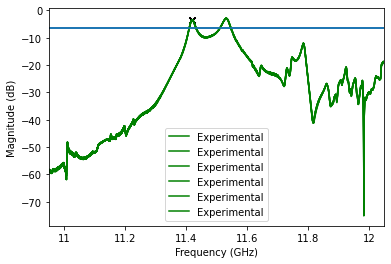

In [8]:
q_arr = np.array([])
coup_arr = np.array([])

# sparTEM = rf.Network(f"data/rustam/transmit with a probe at the end.s2p")
# sparTEM.frequency.unit = "ghz"
# sparTEM.s11.plot_s_db()
# plt.show()

f_min = 11.35 # frequency bound in which the measurement will be fitted
f_max = 11.47
p_to_fit = 5e-3 # a parameter used later for fitting of the measured curve with a circle
mean_couplings = np.empty(2)
adjusted_couplings = np.empty(2)

for sind,sfile in enumerate(("s11","s22")): # the files from which the s11 and s22 measurements will be taken respectively
# for sind, sfile in enumerate(("through", "through")):
# for sind, sfile in enumerate(("through again", "through again")):
    for i in range(1,7):
    # for i in range(3, 4):

        filepath = f"data/rustam/{sfile} {i}.s2p"
        if not os.path.exists(filepath):
            print(f"skipped {i}")
            continue
        spar = rf.Network(filepath)

        spar.frequency.unit = "ghz"
        # spar.crop(11,13)
        if sind:
            trace = spar.s22
        else:
            trace = spar.s11
        plt.close()
        # spar.s11.plot_s_db(linestyle="--", c="r")
        # trace.plot_s_db(linestyle = "--", c = "g")
        trace.plot_s_db(label = "Experimental", c = "g") # this plots the entire measured range
        frq0 = spar.f
        spar.crop(f_min,f_max) # here's cropping to the range specified above
        if sind:
            trace = spar.s22
        else:
            trace = spar.s11


        bw_level = 3 # because we measure bandwidth at -3 dB
        min_db = np.amin(trace.s_db)
        ind_min = np.where(trace.s_db == min_db)[0]
        min_f = spar.f[ind_min]
        min_s_re = trace.s_re[ind_min]
        min_s_im = trace.s_im[ind_min]
        f_l = spar.f[np.argmin(np.abs(trace.s_db[np.where(spar.f < min_f)] - min_db - bw_level))]
        f_h = spar.f[np.where(spar.f > min_f)][np.argmin(np.abs(trace.s_db[np.where(spar.f > min_f)] - min_db - bw_level))]

        # print(min_db,min_f)
        # plt.axhline(min_db + 3)
        trace.plot_s_db(label = None)
        # plt.scatter(min_f,min_db)
        q_loaded = min_f[0]/(f_h-f_l) # the quality factor found from the S11 bandwidth. Untrustworthy.
        # print(q_loaded)
        # trace.plot_z_re()
        # theor_spar = rf.Network("resonator_hex_wires_worse_brass.s2p")
        # theor_spar.s12.plot_s_db(label = "CST",linestyle = "--", c = "b")
        # plt.plot(theor_spar.f, theor_spar.s11.s_db[:,0,0], label = "aaaa")

        # uncomment to see the traces from the VNA
        # plt.show()

        def f(x, a1r,a1i, a2r,a2i, a3r,a3i): #the circular function used for fitting
            t = 2 * (x - min_f) / min_f
            a1 = a1r + a1i*1j
            a2 = a2r + a2i*1j
            a3 = a3r + a3i*1j
            return np.hstack([np.real((a1*t- a2)/(a3*t+1)),np.imag((a1*t- a2)/(a3*t+1))])


        to_fit = np.where((spar.f > min_f**(1-p_to_fit/100))&(spar.f < min_f*(1+p_to_fit/100)))
        opt_a = opt.curve_fit(f,spar.f[to_fit],np.hstack([np.squeeze(trace.s_re)[to_fit],np.squeeze(trace.s_im)[to_fit]])) # Fitting!
        [a1r,a1i, a2r,a2i, a3r,a3i] = opt_a[0]
        app_re = f(frq0,a1r,a1i, a2r,a2i, a3r,a3i)[:frq0.size]
        app_im = f(frq0,a1r,a1i, a2r,a2i, a3r,a3i)[frq0.size:]
        plt.plot(app_re,app_im,ls = "--", c = "g", zorder = 1,linewidth= 3) # plots the fitted circle on a Smith chart
        # print(opt_a[0])
        # print(f(frq0,opt_a[0][0],opt_a[0][1],opt_a[0][2])[:frq0.size],f(frq0,opt_a[0][0],opt_a[0][1],opt_a[0][2])[frq0.size:])

        z0 = 50

        app_min_ind = np.argmax(np.squeeze((app_re)**2+(app_im)**2)) # point on the approximated data that is furthest away from the center
        plt.scatter(app_re[app_min_ind ],app_im[app_min_ind],c = "purple")
        # rf.z2s(app_re+app_im*1j,z0)
        s_circ_re = app_re[app_min_ind ]+app_im[app_min_ind]*1j
        circ_re = np.real(z0*(1+s_circ_re)/(1-s_circ_re)) # This is used to try to account for the losses in the connectors

        #
        # plt.figure
        #
        # plt.plot(f(spar.f,opt_a[0][0],opt_a[0][1],opt_a[0][2]))


        trace.plot_s_smith(label = None, c = "b") # plots the original measurement on a Smith chart
        zim = np.linspace(0,1e2,spar.f.size)*np.sign(np.squeeze(min_s_im))*1j
        zre = np.ones_like(zim)*circ_re
        z = np.expand_dims(np.expand_dims(zim+zre,1),1)
        s_test = rf.z2s(z,z0)

        s11_big_circ = (circ_re-z0)/(circ_re+z0)
        d_big_circ = abs(s11_big_circ)+1
        cent = d_big_circ/2+s11_big_circ # finds the new center of the red circle that accounts for losses. It is later used to approximate bandwidth
        # print(z0*(1+cent)/(1-(cent)))
        z0_2 = z0*(1+cent)/(1-(cent))

        big_circ = rf.Network(f = spar.f, s = s_test, z0 = 50)

        new_min_ind = np.argmin(np.squeeze((trace.s_re-cent)**2+(trace.s_im)**2))
        plt.scatter(trace.s_re[new_min_ind],trace.s_im[new_min_ind],c = "b") # the new farthest point



        new_min_ind_2 = np.argmin(np.squeeze((trace.s_re[new_min_ind]-big_circ.s_re)**2+(trace.s_im[new_min_ind]-big_circ.s_im)**2))
        plt.scatter(big_circ.s_re[new_min_ind_2],big_circ.s_im[new_min_ind_2],c = "b") # the new closest point
        plt.plot(np.squeeze([big_circ.s_re[new_min_ind_2],trace.s_re[new_min_ind]]),
                 np.squeeze([big_circ.s_im[new_min_ind_2],trace.s_im[new_min_ind]]),c= "k",ls = ":")
        d_small_circ = np.sqrt(np.squeeze((big_circ.s_re[new_min_ind_2]-trace.s_re[new_min_ind])**2+
                               (big_circ.s_im[new_min_ind_2]-trace.s_im[new_min_ind])**2))

        # finding index of f_l
        new_left_ind = np.argmin(np.abs(np.squeeze((trace.s_re[new_min_ind] - trace.s_re)**2 + (trace.s_im[new_min_ind]-trace.s_im)**2 -
                                                   (big_circ.s_re[new_min_ind_2] - trace.s_re)**2 - (big_circ.s_im[new_min_ind_2]-trace.s_im)**2))[np.where(spar.f < spar.f[new_min_ind])])
        # finding index of f_h
        new_right_ind = new_min_ind + np.argmin(np.abs(np.squeeze((trace.s_re[new_min_ind] - trace.s_re)**2 + (trace.s_im[new_min_ind]-trace.s_im)**2 -
                                                   (big_circ.s_re[new_min_ind_2] - trace.s_re)**2 - (big_circ.s_im[new_min_ind_2]-trace.s_im)**2))[np.where(spar.f > spar.f[new_min_ind])])
        plt.scatter(trace.s_re[new_left_ind],trace.s_im[new_left_ind], c= "k",marker="s",s = 30,zorder = 3)
        plt.scatter(trace.s_re[new_right_ind],trace.s_im[new_right_ind], c= "k",marker="s",s = 30,zorder = 3)

        plt.plot(np.squeeze([big_circ.s_re[new_min_ind_2],trace.s_re[new_left_ind],trace.s_re[new_min_ind],trace.s_re[new_right_ind],big_circ.s_re[new_min_ind_2]]),
                 np.squeeze([big_circ.s_im[new_min_ind_2],trace.s_im[new_left_ind],trace.s_im[new_min_ind],trace.s_im[new_right_ind],big_circ.s_im[new_min_ind_2]]),
                 c= "k",ls = ":") #draws the square within a circle
        q_loaded_2 = spar.f[new_min_ind]/(spar.f[new_right_ind]-spar.f[new_left_ind]) # the quality factor found from the Smith chart
        # print(q_loaded_2)
        d_small_circ_2 = np.sqrt(np.squeeze((trace.s_re[new_left_ind]-trace.s_re[new_right_ind])**2+
                               (trace.s_im[new_left_ind]-trace.s_im[new_right_ind])**2))

        plt.plot([s11_big_circ,1],[0,0],c="r")
        # print(d_big_circ,d_small_circ,d_small_circ_2)
        coupling = 1/(d_big_circ/d_small_circ-1) # coupling coefficients
        coupling_2 =  1/(d_big_circ/d_small_circ_2-1)
        q_unloaded = q_loaded*(1+coupling) # the unloaded quality factor found from the traces. Bad. I didn't use it
        q_unloaded_2 = q_loaded_2*(1+coupling_2) # the unloaded quality factor found from the Smith chart

        # print(coupling,q_loaded,q_unloaded)
        print(coupling_2,q_loaded_2,q_unloaded_2)

        q_arr = np.append( q_arr,q_loaded_2)
        coup_arr= np.append(coup_arr,coupling_2)


        big_circ.plot_s_smith(label = None,c="r",zorder = -1)
        plt.scatter(min_s_re,min_s_im)
        # plt.scatter(d_big_circ/2,0)
        plt.scatter(cent,0,c="r",marker = "x")

        # Uncomment to see the approximations on the Smith chart
        # plt.show()
    # plt.plot(trace.f,np.squeeze(trace.s_mag))
    # print(cent, trace.f[new_min_ind])
    # plt.plot(trace.f,np.squeeze(np.sqrt((trace.s_re-cent)**2+(trace.s_im)**2)))
    # new_min_ind = np.argmin(np.squeeze((trace.s_re-cent)**2-(trace.s_im)**2))
    #
    # big_circ2 = rf.Network(f = spar.f, s = s_test, z0 = 5)
    plt.close()
    print(coup_arr)
    plt.plot(coup_arr)
    plt.axhline(coup_arr.mean())
    plt.ylim(0.2,0.6)


    mean_couplings[sind] = coup_arr.mean() # the average coupling coefficients for ports 1 and 2
    print(q_arr.mean()) # average loaded quality factor from the reflection measurements. I don't use it later, but it seems to fit with the transmission one well (504 vs 509).
    q_arr = np.array([])
    coup_arr = np.array([])

    # uncomment to see the coupling coefficients from a series of measurements
    # plt.show()

print(mean_couplings)
coup1 = mean_couplings[0]
coup2 = mean_couplings[1]
coup1_adj = coup1*(1+coup2)/(1-coup1*coup2)
coup2_adj = coup2*(1+coup1)/(1-coup1*coup2)
coup_adj = coup1_adj + coup2_adj
print(coup1_adj, coup2_adj, coup_adj) # two coupling coefficients recalculated into a single one

# Now moving on to the transmission measurements

ql_arr = np.array([])
qu_arr = np.array([])
f_arr = np.array([])

plt.close()


for i in range(1, 7):
    spar = rf.Network(f"data/rustam//through again {i}.s2p")
    spar.frequency.unit = "ghz"
    # spar.crop(11,13.5)
    trace = spar.s12
    # trace.plot_s_db(linestyle = "--", c = "g")
    # trace.plot_s_db
    trace.plot_s_db(label="Experimental", c="g")
    #theor_spar = rf.Network("resonator_hex_wires_dogshit_brass.s2p")
    #theor_spar.frequency.unit = "ghz"
    #theor_spar.crop(11, 12)
    #theor_spar.s21.plot_s_db(label="CST", linestyle="--", c="b")

    spar.crop(f_min,f_max)
    # spar.s12.plot_s_db(linestyle="--", c="g")
    # spar.s11.plot_s_db(linestyle="--", c="b")
    # spar.s22.plot_s_db(linestyle="--", c="r")
    trace = spar.s12
    bw_level = -3
    max_db = np.amax(trace.s_db)
    max_mag = np.amax(trace.s_mag)
    ind_max = np.where(trace.s_db == max_db)[0]
    max_f = spar.f[ind_max]
    max_s_re = trace.s_re[ind_max]
    max_s_im = trace.s_im[ind_max]
    f_l = spar.f[np.argmin(np.abs(trace.s_db[np.where(spar.f < max_f)] - max_db - bw_level))]
    f_h = spar.f[np.where(spar.f > max_f)][np.argmin(np.abs(trace.s_db[np.where(spar.f > max_f)] - max_db - bw_level))]

    # print(f_h,f_l)
    print(max_db,max_f[0]/1e9,(f_h-f_l)/1e9)
    plt.axhline(max_db + bw_level) # -3 dB line
    # trace.plot_s_db()
    plt.scatter(max_f,max_db, c = "k", marker="x")
    q_loaded = max_f[0]/(f_h-f_l)
    q_unloaded = q_loaded/(1-max_mag)
    coup_s12 = max_mag/(1-max_mag)/2
    q_unloaded_2 = q_loaded*(1+coup_adj)
    print(max_mag,coup_s12*2,coup_adj)
    print(q_loaded,q_unloaded,q_unloaded_2)


    ql_arr = np.append(ql_arr, q_loaded)
    qu_arr = np.append(qu_arr, q_unloaded_2)
    f_arr = np.append(f_arr, max_f[0]/1e9)

    # uncomment to see the transmission traces
    # plt.show()

# plt.show()
print(ql_arr.mean(), qu_arr.mean()) # final results in regards to the Q factor

print(f_arr.mean(),"\n", f_arr) # Average resonance frequency

# print(spar.f.size, trace.s_db.size)
# fig = go.Figure(data = go.Scatter(x = spar.f, y = trace.s_db, name = 'Low 2014',
#                          line=dict(color='royalblue', width=4)))
# fig.show()
